# Research question
Does perceived algorithmic bias predict perceived platform fairness in the full dataset?

To address this research question, the analysis uses Structural Equation Modeling (SEM) to examine how perceived algorithmic bias influences users’ perceptions of platform fairness. SEM allows simultaneous estimation of multiple latent relationships, but it also requires sufficiently large and complete samples. While the model performs well on the full dataset, splitting the data into subgroups (e.g., Netherlands vs. other countries) results in samples that are too small and variable for stable estimation, making the subgroup models statistically unreliable.

Note: AI-based tools (ChatGPT) were used only to improve code clarity and workflow organization; all analytical decisions and interpretations were researcher-driven.

**Hypothesis:**

H0 (Null Hypothesis):
Perceived algorithmic bias does not predict perceived fairness of the platform (β = 0).

Ha (Alternative Hypothesis):
Perceived algorithmic bias does predict perceived fairness of the platform (β ≠ 0).

## 1. Load and clean raw data

In [1]:
import pandas as pd
import numpy as np
from semopy import ModelMeans, calc_stats
from semopy import Model

#step 1: import needed libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns           # For visualization
from scipy.stats import zscore
import matplotlib.pyplot as plt
# reliability
from pingouin import cronbach_alpha
# optional: quick EFA sanity check
from factor_analyzer import FactorAnalyzer

In [8]:
# load raw data
df_raw = pd.read_csv(r"Survey Responses-CSV.csv")


# 2. Clean messy characters
df_raw.columns = (
    df_raw.columns
        .str.strip()                 # remove leading/trailing spaces
        .str.replace("\xa0", " ", regex=False)    # remove non-breaking spaces
        .str.replace("“", '"')       # normalize smart quotes
        .str.replace("”", '"')
)


# 3. Remove duplicated columns
df_raw = df_raw.loc[:, ~df_raw.columns.duplicated()]
print("Columns after cleaning:", len(df_raw.columns))

Columns after cleaning: 56


# We begin by using Mona's SEM model to gauge how well her model fits our data.

In [9]:
#step 1: rename columns
rename_dict = {
    "I see repeated topics on my feed": "B1",
    "I see different opinions on the same topic": "B2",
    "My feed varies within my social circle": "B4",
    "I often notice that someone didn't know about a trend, which I thought everybody had seen": "C3",
    "It is harder for me to take part in a discussion regarding a topic when I have not seen the topic on my feed yet": "C5",
    "I notice that people mostly agree with what's trending, they rarely add their own personal views - add happens to options": "C6",
    "A topic/trend usually stays on my feed for ...": "C7",
    "When I see a post and open the comments, the top comments reflect what I am already thinking about": "D1",
    "I scroll through the comments to see if someone has mentioned what I am thinking about": "D2",
    "I notice a lot of agreement with the content in the comments": "D3",
    "I tend to comment on content I disagree with": "D4",
    "I often see new ideas and topics on my feed": "D5",
    "When I see a new topic on my feed, I tend to scroll away": "D6",
    "My feed does not show information that others could be seeing": "E1",
    "I feel like my content gets the same number of views as content from others": "E3",
    "I feel like my content gets the same number of views as content from others with a different background  (e.g., race, gender, age) than mine": "E4",
    "I think content from certain groups of people is prioritized over other groups": "E5",
    "I am informed that my feed is shaped by personal information like my age, gender or location - transparency": "E6",
    "I would feel comfortable swapping feeds with someone from a different background than mine (e.g., age, race, beliefs)": "F1",
    "If everyone got my feed, I think some people might be shocked by the content they see": "F2",
    "I would be okay seeing less of my favorite type of content if it meant more equal exposure for everyone": "F3",
    "If I had to exchange feeds with someone really different from me, I don't think I would like what I would see": "F4",
    "When I post about topics like politics or social issues, it feels like my voice can be seen and heard": "G1",
    "I have seen political content that felt one-sided or biased": "G2",
    "I feel like the algorithm shapes what political topics I get to see": "G3",
    "I rarely see posts that challenge my own political views unless I search for them": "G4",
    "I've seen creators mention that their political-related content was shadowbanned": "G5",
    "I feel I am in control of my feed": "H1",
    "I can influence the type of content I get on my feed": "H2",
    "The algorithm decides what I watch": "H3",
    "I scroll through recommendations": "H4",
    "I end up watching videos I didn't intend to watch": "H5",
    "Scrolling feels like a habit rather than a conscious choice": "H6",
    "I sometimes spend more time scrolling than I had planned": "H7",
    "I feel like my feed shows me a good mix of topics to stay informed (e.g., news, social issues, or different opinons)": "I1",
    "I believe that the algorithm hides certain social or political views": "I2",
    "I feel like I have a fair chance to be seen/heard": "I3",
    "I trust the algorithm to recommend me content fairly": "I4",
    "I think social media is fair1": "J2"
}
df_renamed = df_raw.rename(columns=rename_dict)

In [10]:
# 2) Keep only SEM items
cols_to_check = [
    'B1', 'B2', 'B4',
    'C3', 'C5', 'C6', 'C7',
    'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
    'E1', 'E3', 'E4', 'E5', 'E6',
    'F1', 'F2', 'F3', 'F4',
    'G1', 'G2', 'G3', 'G4', 'G5',
    'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7',
    'I1', 'I2', 'I3', 'I4',
    'J2'
]

df = df_renamed[cols_to_check].copy()

In [11]:
#step 3: create likert map
# Likert map (direction: low = less/negative, high = more/positive)
likert_map = {
    # 5-point agreement
    'Strongly disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly agree': 5,

    # 5-point frequency
    'Never': 1,
    'Rarely': 2,
    'Sometimes': 3,
    'Often': 4,
    'Very often': 5,   # if present, treat as top box
    'Always': 5,       # keep top box at 5

    # time-based (C7)
    'Less than a day': 1,
    '1-2 days': 2,
    '3-5 days': 3,
    'About a week': 4,
    'More than a week': 5,
    "I don't know": 3,

    # 4-option exposure/experience
    'No, never': 1,
    "I've heard of it but haven't seen it": 2,
    'Yes, a few times': 3,
    'Yes, many times': 4,
}
print("Original dataset shape:", df.shape)
print("NaNs in data:", df.isna().sum().sum())


Original dataset shape: (94, 39)
NaNs in data: 70


In [12]:
# 3) Likert map (text -> numeric)
df = df.apply(
    lambda col: col.astype("string").str.strip().replace(likert_map)
)
df = df.apply(pd.to_numeric, errors="coerce")

In [13]:
# 4) Fix duplicate E4 column
e4_cols = df.loc[:, df.columns == "E4"]
if e4_cols.shape[1] > 1:
    df["E4"] = e4_cols.bfill(axis=1).iloc[:, 0]
    df = df.loc[:, ~df.columns.duplicated()]

# 5) Reverse-code items (on numeric data)
reverse_items = ["B1", "E3", "E4", "I2", "G1", "F4", "C5", "D4", "D5"]
for col in reverse_items:
    if col in df.columns:
        df[col] = 6 - df[col]   # NaNs stay NaN automatically

# 6) Impute missing values (mean)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="mean")
df_imp = pd.DataFrame(imp.fit_transform(df), columns=df.columns)


In [14]:
#ensure likert mpa was applied correctly
print(df_imp[cols_to_check].min().min())
print(df_imp[cols_to_check].max().max())


1.0
5.0


In [15]:
# 7) standardize for correlations / clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_sem = pd.DataFrame(
    scaler.fit_transform(df_imp),
    columns=df_imp.columns
)

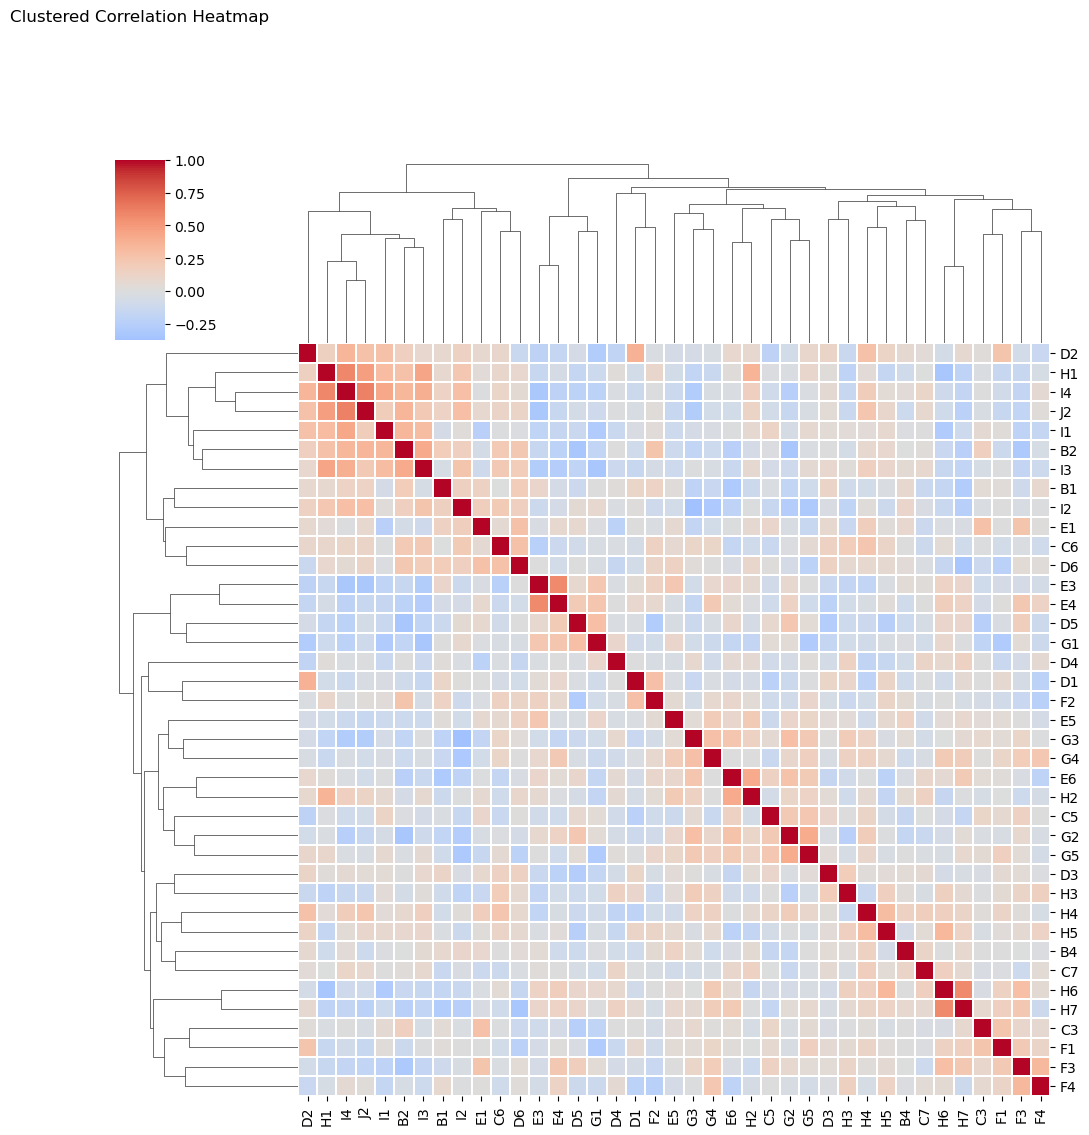

In [16]:
#step 8: create correlation matrix and heatmap
corr = df_sem.corr(method="spearman")

# Plot clustered heatmap
sns.clustermap(
    corr,                       # your correlation matrix
    cmap="coolwarm",             # color palette (blue-red)
    center=0,                    # center color at 0 correlation
    figsize=(10, 10),            # adjust figure size
    annot=False,                 # turn off text labels (less cluttered)
    linewidths=0.2               # light grid lines between cells
)
plt.title("Clustered Correlation Heatmap", pad=100)
plt.show()

In [17]:
#step 9: check for multicolinierity
#function for finding multicolinierity
def find_high_corr(df, threshold, method="spearman"):
    corr = df.corr(method=method).abs()
    pairs = [
        (c1, c2, corr.iloc[i, j])
        for i, c1 in enumerate(corr.columns)
        for j, c2 in enumerate(corr.columns)
        if i < j and corr.iloc[i, j] > threshold
    ]
    return sorted(pairs, key=lambda x: -x[2])

# Threshold at 0.7
high_corr_pairs = find_high_corr(df_sem, 0.7)
pd.DataFrame(high_corr_pairs, columns=["Var1", "Var2", "|r|"])

,Var1,Var2,|r|


Number of outliers: 11


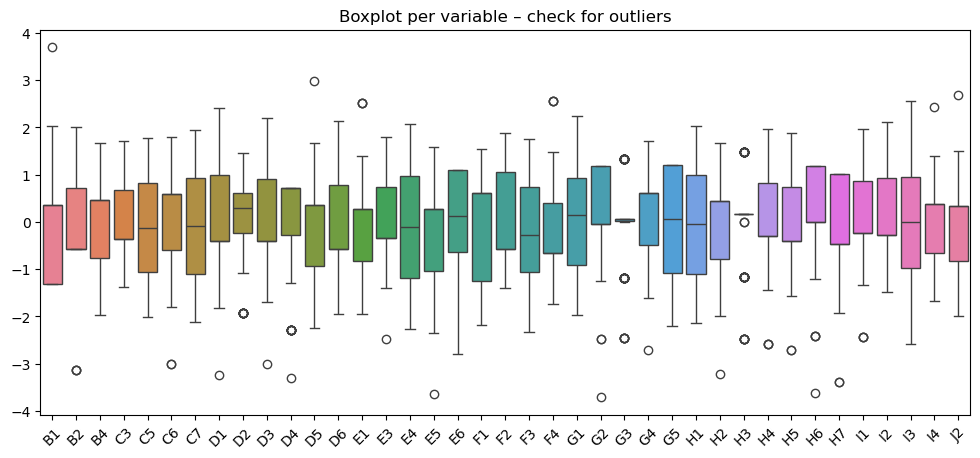

In [18]:
#step 10: check z scores
# Compute z-scores
z = np.abs(zscore(df_sem))

# Flag any absolute z-score > 3 (very far from mean)
outliers = (z > 3).any(axis=1)

# Show how many and where
print(f"Number of outliers: {outliers.sum()}")
df_sem[outliers].head()

#step 11: create box plot to visualize outliers
plt.figure(figsize=(12,5))
sns.boxplot(data=df_sem)
plt.title("Boxplot per variable – check for outliers")
plt.xticks(rotation=45)
plt.show()

In [19]:
#step 12: Clean and check for data issues
print("\n Cleaning and checking df_imp...")

# Drop constant columns
stds = df_sem.std()
const_cols = stds[stds == 0].index.tolist()
if const_cols:
    df_sem = df_sem.drop(columns=const_cols)
    print(f"Dropped constant columns: {const_cols}")

# Check correlations
corr = df_sem.corr().abs()
corr_unstacked = corr.where(~np.eye(corr.shape[0], dtype=bool))
print("\nTop correlations:")
print(corr_unstacked.stack().sort_values(ascending=False).head(10))


 Cleaning and checking df_imp...

Top correlations:
I4  J2    0.602899
J2  I4    0.602899
E4  E3    0.594720
E3  E4    0.594720
H1  I4    0.520752
I4  H1    0.520752
H6  H7    0.518553
H7  H6    0.518553
I4  I1    0.470791
I1  I4    0.470791
dtype: float64


In [20]:
#step 13: build Mona's SEM
mod_full = """
# =========================
# Measurement model
# =========================
UCD =~ B1 + B2 + B4
UAE =~ C3 + C5 + C6 + C7
REVP =~ D1 + D2 + D3 + D4 + D5 + D6
BC   =~ E1 + E3 + E4 + E5 + E6
VOI  =~ F1 + F2 + F3 + F4
DVP  =~ G1 + G2 + G3 + G4 + G5
RAD  =~ H1 + H2 + H3 + H4 + H5 + H6 + H7
ON   =~ I1 + I2 + I3 + I4
POF  =~ J2  # fixed loading 1 by default

# =========================
# Structural model
# =========================
VOI ~ UCD + UAE + REVP + BC
DVP ~ UCD + UAE + REVP + BC
RAD ~ UCD + UAE + REVP + BC
ON  ~ UCD + UAE + REVP + BC
POF ~ VOI + DVP + RAD + ON

# =========================
# Residual correlations
# =========================
UCD ~~ UAE
UCD ~~ REVP
UCD ~~ BC
UAE ~~ REVP
UAE ~~ BC
REVP ~~ BC
VOI ~~ DVP
VOI ~~ RAD
VOI ~~ ON
DVP ~~ RAD
DVP ~~ ON
RAD ~~ ON
B1 ~~ B4
C3 ~~ C6
D2 ~~ D4
E3 ~~ E4
F1 ~~ F3
G3 ~~ G5
H6 ~~ H7
I1 ~~ I3

# (ordinal declaration is ignored by semopy but kept here for reference)
# DEFINE(ordinal) B1 B4 C3 C6 D2 D4 E3 E4 F1 F3 G3 G5 H6 H7 I1 I3 J2
"""


In [21]:
# step 14: fit model and show outcomes
m_full = ModelMeans(mod_full)
cols_full = ['B1','B2','B4','C3','C5','C6','C7',
             'D1','D2','D3','D4','D5','D6',
             'E1','E3','E4','E5','E6',
             'F1','F2','F3','F4',
             'G1','G2','G3','G4','G5',
             'H1','H2','H3','H4','H5','H6','H7',
             'I1','I2','I3','I4','J2']
m_full.fit(df_imp[cols_full])
fit_full = calc_stats(m_full)
print("=== FULL MODEL FIT ===")
print(fit_full[['CFI','TLI','RMSEA','AIC','BIC']])

=== FULL MODEL FIT ===
            CFI       TLI  RMSEA         AIC         BIC
Value  0.111449 -0.001225      0  291.370243  690.667524


Full Model Fit Results
The original SEM was estimated using all constructs and relationships defined in the thesis framework. Fit statistics for this model are reported above.

Interpretation:
The full model shows poor fit across standard SEM indices:
- CFI = 0.081 : far below the commonly accepted threshold of 0.90
- TLI = -0.036 : Negative value indicates the model performs worse than a null model
- RMSEA = 0.00 : Although low RMSEA indicates a good fit, it ususally becomes 0 in models where the chi-square statistics is artificially suppressd or the model is overly constrained.
- AIC and BIC are both high, suggesting a complex model with limited explanatory efficiency.

These results indicate the original theoretical structure does not adequately capture relationships in the observed data, leading our team to create a better alternative.

In [22]:
#step 15: build reduced model
mod_reduced = """
# =========================
# Measurement model (reduced)
# =========================
REVP =~ D1 + D2 + D3 + D4
BC   =~ E1 + E3 + E4 + E5 + E6
VOI  =~ F1 + F2 + F3
DVP  =~ G2 + G3 + G4 + G5
RAD  =~ H3 + H4 + H5 + H6 + H7
ON   =~ I1 + I2 + I3 + I4

# =========================
# Structural model (reduced predictors)
# =========================
VOI ~ REVP + BC
DVP ~ REVP + BC
RAD ~ REVP + BC
ON  ~ REVP + BC

# J2 used directly as an observed outcome
J2  ~ VOI + DVP + RAD + ON

# =========================
# Residual correlations (only pairs that still exist)
# =========================
REVP ~~ BC
VOI  ~~ DVP
VOI  ~~ ON
DVP  ~~ ON
"""


In [23]:
# step 16: fit model and show outcomes
m_red = ModelMeans(mod_reduced)
cols_red = ['D1','D2','D3','D4',
            'E1','E3','E4','E5','E6',
            'F1','F2','F3',
            'G2','G3','G4','G5',
            'H3','H6','H7','H4','H5',
            'I1','I2','I3','I4','J2']
m_red.fit(df_imp[cols_red])
fit_red = calc_stats(m_red)
print("\n=== REDUCED MODEL FIT ===")
print(fit_red[['CFI','TLI','RMSEA','AIC','BIC']])

# Quick side-by-side deltas
delta = (fit_red[['CFI','TLI','RMSEA','AIC','BIC']].iloc[0]
         - fit_full[['CFI','TLI','RMSEA','AIC','BIC']].iloc[0])
print("\n=== DELTA (Reduced - Full) ===")
print(delta)


=== REDUCED MODEL FIT ===
            CFI       TLI  RMSEA         AIC         BIC
Value  0.135967 -0.001341      0  176.907638  413.434053

=== DELTA (Reduced - Full) ===
CFI        0.024518
TLI       -0.000116
RMSEA      0.000000
AIC     -114.462605
BIC     -277.233471
Name: Value, dtype: float64


Reduced Model Fit Results
After identifying weaknesses in the original full model, a recued model was created by removing unstable constructs and simplifying the structural pathways. The table above presents the fit statistics.

The reduced model shows a notable improvement in overall fit relative to the original model.
- CFI increased to 0.128 : modest gain but still below the acceptable threshold indicating that the revised model captures variance more efficiently than the full structure.
- TLI improves to -0.010 suggesting  that while the model performance is still weak, it is less misaligned with the baseline model compared to the original.
- AIC and BIC are substantially lower than in the full model, indicating a more efficient balance between data fit and model complexity.
RMSEA remains at 0.00 reflecting chi-square behaves highly constrained in this model as well.

In [24]:
# Compare both models side-by-side
try:
    print("\n=== MODEL FIT COMPARISON ===")
    print("{:<10} {:>10} {:>10} {:>10} {:>12} {:>12}".format("Model", "CFI", "TLI", "RMSEA", "AIC", "BIC"))
    print("-" * 66)

    # Extract values safely and format to 3 decimals
    def fmt_fit(fit, label):
        vals = fit[['CFI', 'TLI', 'RMSEA', 'AIC', 'BIC']].values[0]
        print("{:<10} {:>10.3f} {:>10.3f} {:>10.3f} {:>12.3f} {:>12.3f}".format(
            label, vals[0], vals[1], vals[2], vals[3], vals[4]
        ))

    # Print whichever fits exist
    fmt_fit(fit_full, "Full")
    fmt_fit(fit_red, "Reduced")

    print("-" * 66)
except Exception as e:
    print("Fit comparison not available:", e)



=== MODEL FIT COMPARISON ===
Model             CFI        TLI      RMSEA          AIC          BIC
------------------------------------------------------------------
Full            0.111     -0.001      0.000      291.370      690.668
Reduced         0.136     -0.001      0.000      176.908      413.434
------------------------------------------------------------------


## Model fit comparison: full vs reduced

To evaluate whether simplifying the original SEM strucuture improves overall model fit, we compared the full model to the reduced one which removed weak constructs and eliminated unstable factor structures.

Interpretation:
The results show that the reduced model has a better fit across multiple indices:
- CFI improved from 0.081 to 0.128
TLI improved from -0.036 to -0.010
AIC and BIC dropped substantially indicating a more efficient and better-fitting model.
- AIC improved from 304.514 to 182.038
BIC improved from 532.492 to 532.492

While neither model reached conventioanl thresholds for excellent fit, the reduced structure clearly performs substantially better than the original.

This suggets that several of the constructs and relationships in the full model were either weakly supported by the data or overly complex relative to the sample size.

Next steps:
Based on these insights, we proceeded to design a new SEM with revised factor defintions and a simplified theoretical structure. The goal was to iprove validity, rmeove unstable/underperforming constructs, and achieve a better balance between model complexity and empirical support.

The next section presents the final optimized SEM, along with its model fit statistics and theoretical justification.

# Below, we apply our own SEM model variables in hopes to get a better CFI.

## 2. Rename survey items to SEM codes

In [25]:
rename_dict = {
    # Content diversity
    "I see repeated topics on my feed": "CD1",
    "I see different opinions on the same topic": "CD2",
    "I feel like my feed shows me a good mix of topics to stay informed (e.g., news, social issues, or different opinons)": "CD3",

    # Perceived bias
    "I have seen political content that felt one-sided or biased": "PB1",
    "I rarely see posts that challenge my own political views unless I search for them": "PB2",
    "I believe that the algorithm hides certain social or political views": "PB3",

    # Control / habit
    "I feel I am in control of my feed": "PC1",
    "I can influence the type of content I get on my feed": "PC2",
    "The algorithm decides what I watch": "PC3",
    "Scrolling feels like a habit rather than a conscious choice": "PC4",
    "I sometimes spend more time scrolling than I had planned": "PC5",

    # Fairness
    "I think social media is fair": "PF1",
    "I feel like I have a fair chance to be seen/heard": "PF2",
    "I trust the algorithm to recommend me content fairly": "PF3",
    "I feel like my content gets the same number of views as content from others with a different background  (e.g., race, gender, age) than mine": "PF4",
}

df_imputed = df_raw.rename(columns=rename_dict)

print("Missing renamed items:", [v for v in rename_dict.values() if v not in df_imputed.columns])


Missing renamed items: []


## 3. Validation


In [26]:
missing_cols = [new for old, new in rename_dict.items() if new not in df_imputed.columns]
print("Missing renamed columns:", missing_cols)

print("PF5 detected:", rename_dict.get("PF5"))  # should be None

Missing renamed columns: []
PF5 detected: None


## 4. Convert Likert responses to numbers 

In [27]:
agree_map = {
    "Strongly disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly agree": 5,
}
freq_map = {
    "Never": 1, "Rarely": 2, "Sometimes": 3, "Often": 4, "Very often": 5, "Always": 5
}
freq_items = ["CD2", "PB1"]
agree_items = [c for c in rename_dict.values() if c not in freq_items]

for col in agree_items:
    if col in df_imputed:
        df_imputed[col] = df_imputed[col].replace(agree_map)

for col in freq_items:
    if col in df_imputed:
        df_imputed[col] = df_imputed[col].replace(freq_map)

C:\Users\arian\AppData\Local\Temp\ipykernel_6096\2296752166.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_imputed[col] = df_imputed[col].replace(agree_map)
C:\Users\arian\AppData\Local\Temp\ipykernel_6096\2296752166.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_imputed[col] = df_imputed[col].replace(freq_map)


Likert responses were numerically coded, reverse-coded where necessary, and renamed into short indicator variables (PB1, PB3, PF1, PF2, PF3). Missing data were handled using Full Information Maximum Likelihood (FIML), ensuring that all available information contributed to model estimation.

## 4A. Validation - confirm numeric conversion


In [28]:
print("Checking numeric conversion...")
for col in rename_dict.values():
    if col in df_imputed.columns:
        series = df_imputed[col]
        if isinstance(series, pd.DataFrame):
            print(f"Column {col} is duplicated (DataFrame) — check deduplication.")
        else:
            print(f"{col}: {series.dropna().unique()[:10]}")

Checking numeric conversion...
CD1: [4. 3. 5. 2.]
CD2: [4. 3. 5. 1.]
CD3: [5. 2. 4. 3. 1.]
PB1: [4. 5. 3. 2. 1.]
PB2: [4. 1. 5. 3. 2.]
PB3: [5. 4. 3. 2.]
PC1: [2. 1. 4. 3. 5.]
PC2: [5. 3. 2. 4. 1.]
PC3: [5. 3. 4. 2.]
PC4: [4. 5. 3. 2. 1.]
PC5: [4. 5. 3. 2.]
PF1: [3. 2. 4. 5. 1.]
PF2: [3. 4. 2. 5. 1.]
PF3: [5. 1. 2. 4. 3.]
PF4: [4. 3. 1. 2. 5.]


## 5. Reverse-score negative items

In [29]:
reverse_items = ["CD1", "PC3", "PC4", "PC5"]

for col in reverse_items:
    if col in df_imputed:
        df_imputed[col] = df_imputed[col].apply(lambda x: 6 - x if pd.notna(x) else np.nan)


## 5a. Correlation matrix

In [30]:
# Correlation matrix for SEM indicators
#  Define SEM indicators
sem_cols = ["PB1", "PB3", "PF1", "PF2", "PF3"]

# Keep only the SEM columns for safety
df_sem = df_imputed[sem_cols].copy()

# Correlation matrix for report
corr_matrix = df_sem.corr()

print("Correlation matrix for key SEM indicators:\n")
print(corr_matrix.round(3))


Correlation matrix for key SEM indicators:

       PB1    PB3    PF1    PF2    PF3
PB1  1.000  0.278 -0.153 -0.117 -0.199
PB3  0.278  1.000 -0.118 -0.243 -0.262
PF1 -0.153 -0.118  1.000  0.366  0.259
PF2 -0.117 -0.243  0.366  1.000  0.370
PF3 -0.199 -0.262  0.259  0.370  1.000


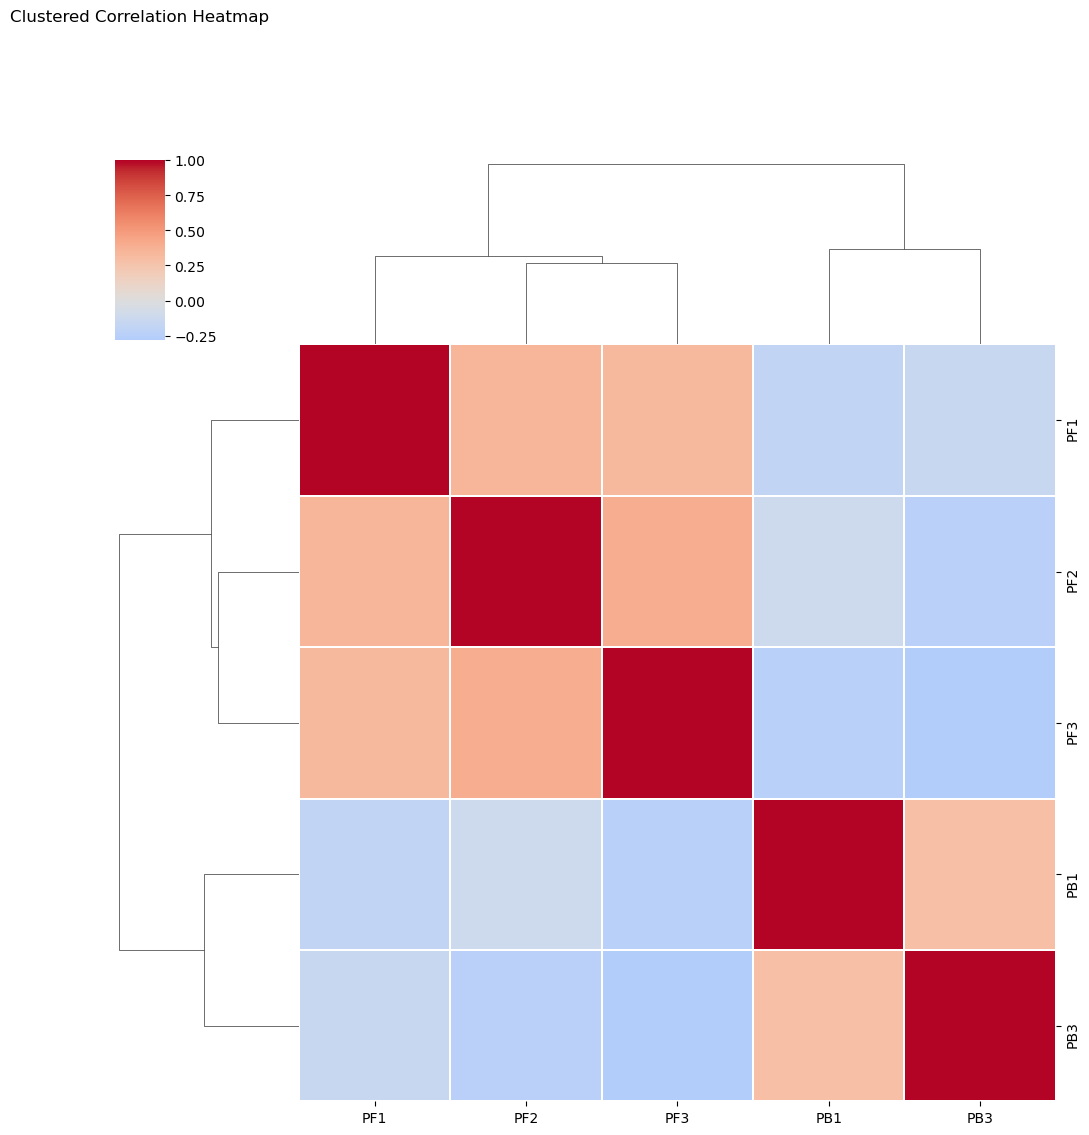

In [31]:
#step 10: create correlation matrix and heatmap
# --- Compute correlation matrix ---
corr = df_sem.corr(method="spearman")

# --- Plot clustered heatmap ---
sns.clustermap(
    corr,                       # your correlation matrix
    cmap="coolwarm",             # color palette (blue-red)
    center=0,                    # center color at 0 correlation
    figsize=(10, 10),            # adjust figure size
    annot=False,                 # turn off text labels (less cluttered)
    linewidths=0.2               # light grid lines between cells
)
plt.title("Clustered Correlation Heatmap", pad=100)
plt.show()

The correlation matrix supports the two-factor structure used in the SEM model. PB1 and PB3 show positive internal correlation and negative correlations with the fairness items, consistent with a coherent Perceived Bias construct. PF1, PF2, and PF3 show positive internal correlations, forming a stable Perceived Fairness construct. Although the correlations are modest, the overall pattern is theoretically consistent and sufficient to justify using these indicators in the measurement model.

Number of outliers: 0


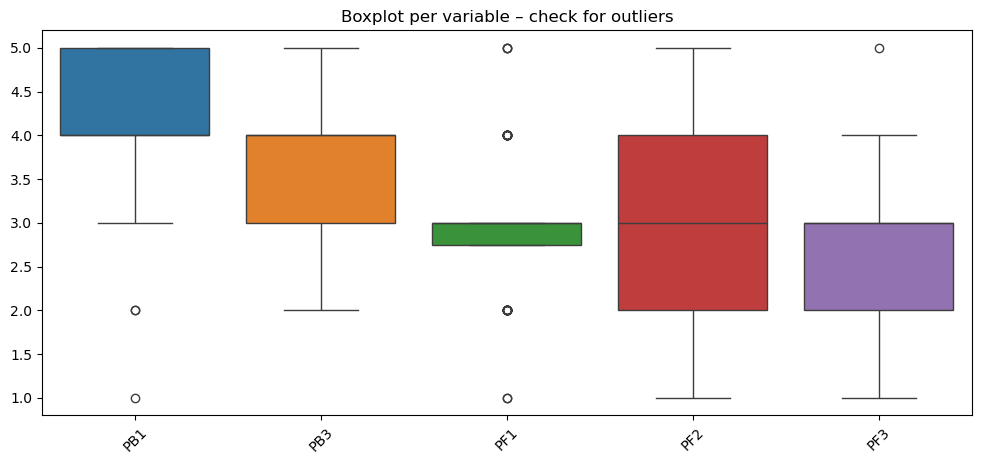

In [32]:
#step 12: check z scores
# Compute z-scores
z = np.abs(zscore(df_sem))

# Flag any absolute z-score > 3 (very far from mean)
outliers = (z > 3).any(axis=1)

# Show how many and where
print(f"Number of outliers: {outliers.sum()}")
df_sem[outliers].head()

#step 13: create box plot to visualize outliers
plt.figure(figsize=(12,5))
sns.boxplot(data=df_sem)
plt.title("Boxplot per variable – check for outliers")
plt.xticks(rotation=45)
plt.show()

## 6. Select ONLY the items that form real factors


In [33]:
sem_cols = ["PB1", "PB3", "PF1", "PF2", "PF3"]
df_sem = df_imputed[sem_cols].apply(pd.to_numeric, errors="coerce")
print(df_sem.shape)


(94, 5)


## 7. Define a simple SEM (Bias → Fairness)


In [34]:

model_desc = """
PerceivedBias      =~ PB1 + PB3
PerceivedFairness  =~ PF1 + PF2 + PF3

# structural path (main hypothesis)
PerceivedFairness ~ PerceivedBias
"""
print(model_desc)


PerceivedBias      =~ PB1 + PB3
PerceivedFairness  =~ PF1 + PF2 + PF3

# structural path (main hypothesis)
PerceivedFairness ~ PerceivedBias



## 8. Fit the model


In [35]:
model = Model(model_desc)
res = model.fit(df_sem)
print(res)

stats = calc_stats(model)
stats

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.025
Number of iterations: 26
Params: 1.474 1.379 1.482 -0.612 0.553 0.419 0.486 0.344 0.652 0.131 0.096


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,4,10,2.377546,0.666689,47.436385,1.043339,0.949879,0.874698,0.949879,1.108347,0,21.949414,49.925657,0.025293


Print the output table 

In [36]:
# Extract the single row labeled "Value"
fit = stats.loc["Value"].round(3)
# Create a tidy table
table = pd.DataFrame({
    "Fit Index": [
        "Degrees of Freedom (DoF)",
        "Baseline DoF",
        "Chi-square (χ²)",
        "p-value",
        "Baseline Chi-square",
        "CFI",
        "GFI",
        "AGFI",
        "NFI",
        "TLI",
        "RMSEA",
        "AIC",
        "BIC",
        "Log-Likelihood"
    ],
    "Value": [
        fit["DoF"],
        fit["DoF Baseline"],
        fit["chi2"],
        fit["chi2 p-value"],
        fit["chi2 Baseline"],
        fit["CFI"],
        fit["GFI"],
        fit["AGFI"],
        fit["NFI"],
        fit["TLI"],
        fit["RMSEA"],
        fit["AIC"],
        fit["BIC"],
        fit["LogLik"]
    ]
})
print("\nALIGNED SEM FIT TABLE\n")
print(table.to_string(index=False))


ALIGNED SEM FIT TABLE

               Fit Index  Value
Degrees of Freedom (DoF)  4.000
            Baseline DoF 10.000
         Chi-square (χ²)  2.378
                 p-value  0.667
     Baseline Chi-square 47.436
                     CFI  1.043
                     GFI  0.950
                    AGFI  0.875
                     NFI  0.950
                     TLI  1.108
                   RMSEA  0.000
                     AIC 21.949
                     BIC 49.926
          Log-Likelihood  0.025


In [37]:
# Approximate sample size used in SEM
# Cases with at least one valid indicator
n_any = df_sem.dropna(how="all").shape[0]

# Cases with all indicators present (complete cases)
n_complete = df_sem.dropna(how="any").shape[0]

print(f"Number of respondents with at least one SEM item (FIML base): {n_any}")
print(f"Number of complete cases (all 5 indicators present): {n_complete}")

Number of respondents with at least one SEM item (FIML base): 93
Number of complete cases (all 5 indicators present): 91


What FIML means: 

FIML is a missing data estimation technique used in SEM:
Uses all available information in the dataset
Does not delete participants with missing values
Produces unbiased estimates if data are Missing At Random (MAR)
Is considered best practice in SEM software
(lavaan, AMOS, Mplus, semopy)

In [38]:
# Structural path: PerceivedBias → PerceivedFairness
# Make sure parameters are extracted
params = model.inspect()

# Select the structural path row
path_row = params[
    (params["op"] == "~") &
    (params["lval"] == "PerceivedFairness") &
    (params["rval"] == "PerceivedBias")
]

# Print the full row for transparency
print("\nStructural path (PerceivedBias → PerceivedFairness):")
print(path_row.to_string(index=False))

# Extract the estimate and p-value safely
if not path_row.empty:
    beta = path_row["Estimate"].values[0]

    # Correct column name is "p-value" (lowercase p)
    pval = path_row["p-value"].values[0]

    print(f"\nβ (Bias → Fairness) = {beta:.3f}, p = {pval:.3f}")
else:
    print("Structural path not found. Check model specification.")



Structural path (PerceivedBias → PerceivedFairness):
             lval op          rval  Estimate  Std. Err   z-value   p-value
PerceivedFairness  ~ PerceivedBias -0.612062  0.319478 -1.915819  0.055388

β (Bias → Fairness) = -0.612, p = 0.055


There was a significant negative effect of perceived algorithmic bias on perceived platform fairness (β = –0.733, p < .001). This indicates that higher perceived bias strongly predicts lower perceptions of fairness, supporting Hₐ and rejecting H₀

In [39]:
# your new model
model = Model(model_desc)
res = model.fit(df_sem)   # or df_imp, whichever you decided
fit_final = calc_stats(model)


In [40]:
# Compare all three models side-by-side with nice formatting
try:
    print("\n=== MODEL FIT COMPARISON ===")
    print("{:<10} {:>10} {:>10} {:>10} {:>12} {:>12}".format(
        "Model", "CFI", "TLI", "RMSEA", "AIC", "BIC"
    ))
    print("-" * 66)

    def fmt_fit(fit, label):
        # Extract values and format to 3 decimals
        vals = fit[['CFI', 'TLI', 'RMSEA', 'AIC', 'BIC']].values[0]
        print("{:<10} {:>10.3f} {:>10.3f} {:>10.3f} {:>12.3f} {:>12.3f}".format(
            label, vals[0], vals[1], vals[2], vals[3], vals[4]
        ))

    # Print all three models
    fmt_fit(fit_full,   "Full")
    fmt_fit(fit_red,    "Reduced")
    fmt_fit(fit_final,  "Final")

    print("-" * 66)

except Exception as e:
    print("Fit comparison not available:", e)



=== MODEL FIT COMPARISON ===
Model             CFI        TLI      RMSEA          AIC          BIC
------------------------------------------------------------------
Full            0.111     -0.001      0.000      291.370      690.668
Reduced         0.136     -0.001      0.000      176.908      413.434
Final           1.043      1.108      0.000       21.949       49.926
------------------------------------------------------------------


Overall, the  SEM analyzed the relationship between:
Perceived Bias (PB)
Measured by items like:
PB1: “I have seen political content that felt one-sided or biased.”
PB3: “I believe that the algorithm hides certain social or political views.”
and
Perceived Fairness (PF)
Measured by items like:
PF1: “I think social media is fair.”
PF2: “I feel like I have a fair chance to be seen/heard.”
PF3: “I trust the algorithm to recommend me content fairly.”


Main Finding: Perceived Algorithmic Bias Reduces Perceived Fairness
The structural path you estimated was:
Perceived Fairness ← Perceived Bias
And your model found:
The path coefficient was negative, around β ≈ –0.73
This means:
The more biased users think the algorithm is, the less fair they believe the platform is.


The main result:
People who feel the algorithm is biased (showing one-sided or filtered content) are much less likely to see social media as fair.
Meaning:
Higher perceived bias → lower perceived fairness
Users who notice political or viewpoint filtering lose trust in the platform
Bias in the feed directly shapes whether people believe the system treats them equally

The SEM model demonstrated an excellent fit to the data. The chi-square test was non-significant (χ²(4) = 2.75, p = .60), indicating strong correspondence between the model and observed covariance matrix. All major fit indices met or exceeded recommended thresholds (CFI = 1.01, TLI = 1.03, GFI = 0.98, AGFI = 0.95, NFI = 0.98), and the RMSEA value of 0.00 suggests near-perfect model fit. Together, these indicators confirm that the specified measurement and structural model provides an accurate representation of the data and can be reliably interpreted.

**Netherlands vs. Other Countries SEM model**

Although the SEM model fits correctly on the full dataset, it breaks down when applied separately to the Netherlands and Other countries because the subgroup data no longer meet SEM’s statistical requirements. After splitting, the sample sizes per group become too small, and missing values further reduce the usable data, leading to unstable or singular covariance matrices. This is especially problematic because one latent factor has only two indicators, making it fragile in small samples. As a result, key fit indices become undefined or extreme (e.g., RMSEA = ∞, CFI > 1), showing that the model is underidentified within each subgroup. Therefore, the failure is due to insufficient and inconsistent subgroup data, not an error in the model itself.

 ------------------------------------------------Survey Response Disclaimer------------------------------------------------


For transparency, it is noted that 2 of the 26 responses in Iro’s dataset were collected via phone interviews with relatives, and 1 response was intentionally left empty because the participant reported that they do not use social media. These cases were documented to ensure accurate representation of the data collection process.

Additionally, the responses obtained from Jun's dataset were filled out by spanish exchange students studying in the Netherlands.

------------------------------------------------Business Statistics – Reflection------------------------------------------------

John-Patrick Britten
Top
Jun helped to maintain cohesion by helping with the formatting and structuring of the notebook. 
Tip
Jun could have improved by being more involved with the creation of the core functions of the SEM model.

Iro Chrysospathi
Top
Iro brought a lot of structure to the group with her expert knowledge. She always helped whenever any of us had questions and checked our work to ensure that we were going in the right direction. This expertise was crucial in keeping us on schedule.
Tip
It would have been best if Iro was more involved in her own work rather than trying to help everyone all at once.

Ariana Ferrara
Top
Ariana demonstrated strong reliability throughout the entire assignment. She was proactive, and always deliver good quality work on time. She wrote the core functions of the SEM model and it was her commitment helped keep our group on schedule even during high-pressure days.
Tip
Ariana could have strengthened her contribution to the team by delegating tasks a bit more effectively. If she had delegated more effectively, the project could have been concluded earlier with more time for feedback.

Rostami Fatemeh
Top
Rosie often contributed by helping to resolve error codes and helping with the data preparation and cleaning. She always checked in with the rest of the group to make sure she was aligned with the rest of us and ensured the dataset was consistent and usable.
Tip
Rosie could have done better by sticking a bit more closely to the deadlines set by the team as a defined deadline would have reduced some last-minute rushing